<a href="https://colab.research.google.com/github/SofiaMarchesi/House-Prices_k/blob/master/House_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [188]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive',force_remount=True)
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datasets/houses_train.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datasets/houses_test.csv')

best_sub = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datasets/best_submission.csv')

Mounted at /content/drive


In [189]:
test_id = test['Id']

train_id = train['Id']

In [190]:
#pip install hyperopt

In [191]:
pip install bayesian-optimization

In [192]:
pip install scikit-optimize


# 1.   Libraries



In [193]:
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import statsmodels as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p


from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet,SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,VotingRegressor,AdaBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_log_error,mean_squared_error
from bayes_opt import BayesianOptimization
from skopt import BayesSearchCV


from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV
from xgboost import XGBRegressor
import xgboost as xgb

In [194]:
import sklearn
sklearn.__version__

'0.22.2.post1'

# 2.   Copy raw data



In [195]:
train1 = train.copy()
test1 = test.copy()

#train1.drop('Id',axis=1, inplace=True)
#test1.drop('Id',axis=1, inplace=True)

print(train1.shape)
print(test1.shape)


(1460, 81)
(1459, 80)


In [196]:
#Show all rows without truncate

pd.set_option('display.max_rows', train1.shape[0]+1)

In [197]:
print(display(train1.head(10)))

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,...,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,...,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,...,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,...,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,

None


In [198]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [199]:
test1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [200]:
train1.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


# 3. Treating NaN values
- Make a function to fill null (NaN) values with a given value
- In categorical/object, it will be fill with 'NA' or 'None', depends of the type of the feature

In [201]:
def FillNa(df,value):
  df = df.fillna(value)
  return df

# Alley
- Analyse 'Alley' - lot of values null: 1369 - 93%
- There is 3 types: Gravel, Paved and No alley acess.
- NaN = No Alley Acess, fill with 'NA'

In [202]:
train1 = train.copy()
test1 = test.copy()

In [203]:
train1[~train1.Alley.isna()].groupby('Alley')['Alley'].count()

Alley
Grvl    50
Pave    41
Name: Alley, dtype: int64

In [204]:
train1['Alley']=FillNa(train1.Alley,'NA')
test1['Alley']=FillNa(test1.Alley,'NA')

# MasVnrType and MasVnrArea
- Analyse MasVnrType e MasVnrArea, both with the same number of NaN: 8
- The NaN refers to the same houses
- [MasVnrType] Great number of houses is in 'None' (59%), so, will be fill with 'None' the 'NaN'.
- [MasVnrArea] with the same logic of MasVnrType, but fill with 0.0, because in this case, is a continuous value.

In [205]:
#The same houses have the 'NaN' in the both features, so the treat will be the same
print(train1['MasVnrType'][train1.MasVnrType.isna()])
print(train1['MasVnrArea'][train1.MasVnrArea.isna()])

234     NaN
529     NaN
650     NaN
936     NaN
973     NaN
977     NaN
1243    NaN
1278    NaN
Name: MasVnrType, dtype: object
234    NaN
529    NaN
650    NaN
936    NaN
973    NaN
977    NaN
1243   NaN
1278   NaN
Name: MasVnrArea, dtype: float64


In [206]:
train1.MasVnrType.value_counts(normalize=True)

None       0.595041
BrkFace    0.306474
Stone      0.088154
BrkCmn     0.010331
Name: MasVnrType, dtype: float64

In [207]:
train1.MasVnrArea.value_counts(normalize=True,sort=True).iloc[:11]

0.0      0.592975
72.0     0.005510
180.0    0.005510
108.0    0.005510
120.0    0.004821
16.0     0.004821
80.0     0.004132
200.0    0.004132
106.0    0.004132
340.0    0.004132
170.0    0.003444
Name: MasVnrArea, dtype: float64

In [208]:
train1['MasVnrType'] = FillNa(train1['MasVnrType'],'None')
train1['MasVnrArea'] = FillNa(train1['MasVnrArea'],0.0)

test1['MasVnrType']=FillNa(test1['MasVnrType'],'None')
test1['MasVnrArea'] = FillNa(test1['MasVnrArea'],0.0)


In [209]:
train1.MasVnrType.shape

(1460,)

In [210]:
train1.MasVnrArea.shape

(1460,)

# BsmtQual, BsmtCond, BstmExposure, BstmFinType1, BstmFinType2
- All with 37 NaN, and refers to the same houses.
- Will be fill with 'NA'

In [211]:
index_Qual = train1.BsmtQual[train1.BsmtQual.isna()].index

index_Cond = train1.BsmtCond[train1.BsmtCond.isna()].index

index_Exp = train1.BsmtExposure[train1.BsmtExposure.isna()].index

index_Type1 = train1.BsmtFinType1[train1.BsmtFinType1.isna()].index

index_Type2 = train1.BsmtFinType2[train1.BsmtFinType2.isna()].index


In [212]:
print('BsmtQual \n')
print(train1.BsmtQual.value_counts())
print('\nBsmtCond\n')
print(train1.BsmtCond.value_counts())
print('\nBsmtExposure\n')
print(train1.BsmtExposure.value_counts())
print('\nBsmtFinType1\n')
print(train1.BsmtFinType1.value_counts())
print('\nBsmtFinType2\n')
print(train1.BsmtFinType2.value_counts())

BsmtQual 

TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

BsmtCond

TA    1311
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64

BsmtExposure

No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64

BsmtFinType1

Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64

BsmtFinType2

Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64


In [213]:
train1.BsmtQual = FillNa(train1.BsmtQual,'NA')
train1.BsmtCond = FillNa(train1.BsmtCond,'NA')
train1.BsmtExposure = FillNa(train1.BsmtExposure,'NA')
train1.BsmtFinType1 = FillNa(train1.BsmtFinType1,'NA')
train1.BsmtFinType2 = FillNa(train1.BsmtFinType2,'NA')


test1.BsmtQual = FillNa(test1.BsmtQual,'NA')
test1.BsmtCond = FillNa(test1.BsmtCond,'NA')
test1.BsmtExposure = FillNa(test1.BsmtExposure,'NA')
test1.BsmtFinType1 = FillNa(test1.BsmtFinType1,'NA')
test1.BsmtFinType2 = FillNa(test1.BsmtFinType2,'NA')


# Electrical 
- 1 NaN
- Fill with the most commmon: 'SBrkr'

In [214]:
train1.Electrical.value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [215]:
train1.Electrical = FillNa(train1.Electrical,'SBrkr')

test1.Electrical = FillNa(test1.Electrical,'SBrkr')

# FirePlacesQu
- 690 NaN
- Verifying the values of 'FirePlace', witch are complete, there are 690 houses without fireplaces and 690 'NaN' in 'FirePlaceQu'. So, it will be fill with 'NA'.


In [216]:
print(train1.Fireplaces.value_counts())

0    690
1    650
2    115
3      5
Name: Fireplaces, dtype: int64


In [217]:
train1.FireplaceQu = FillNa(train1.FireplaceQu,'NA')

test1.FireplaceQu = FillNa(test1.FireplaceQu,'NA')

# [Garages] GarageType, GarageFinish, GarageCars, GarageAreas,GarageQual, GarageCond
- Have 81 NaN.
- Compare the GarageCars and GarageArea witch are complete, with the incomplete features.
- So, the number of 0 in Garagecars match with the NaN of the another NaN features. Will be fill with 'NA'

In [218]:
print(train1.GarageCars.value_counts())
print(train1.GarageType.value_counts())


train1.GarageType=FillNa(train1.GarageType,'NA')
#GarageYrBlt will be fit in the section of features engireering
#train1.GarageYrBlt=FillNa(train1.GarageYrBlt,0.0)
train1.GarageFinish=FillNa(train1.GarageFinish,'NA')
train1.GarageQual=FillNa(train1.GarageQual,'NA')
train1.GarageCond=FillNa(train1.GarageCond,'NA')


test1.GarageType=FillNa(test1.GarageType,'NA')
test1.GarageFinish=FillNa(test1.GarageFinish,'NA')
test1.GarageQual=FillNa(test1.GarageQual,'NA')
test1.GarageCond=FillNa(test1.GarageCond,'NA')
#GarageYrBlt will be fit in the section of features engireering
#test1.GarageYrBlt=FillNa(test1.GarageYrBlt,0.0)



2    824
1    369
3    181
0     81
4      5
Name: GarageCars, dtype: int64
Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64


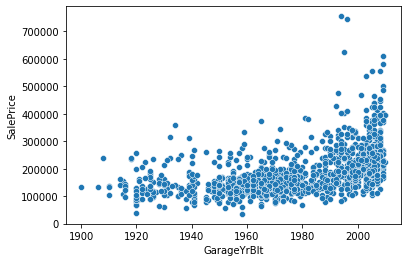

In [219]:
sns.scatterplot(x='GarageYrBlt',y='SalePrice', data=train1,)

# Pool
- PoolArea,PoolQC(7 Non-null)
- Just 7 with values! Probably, this feature will be drop. But now, will fill with 'NA'

In [220]:
train1.PoolQC[~train1.PoolQC.isna()]


197     Ex
810     Fa
1170    Gd
1182    Ex
1298    Gd
1386    Fa
1423    Gd
Name: PoolQC, dtype: object

In [221]:
train1.PoolArea.value_counts()

0      1453
738       1
648       1
576       1
555       1
519       1
512       1
480       1
Name: PoolArea, dtype: int64

In [222]:
train1.PoolQC=FillNa(train1.PoolQC,'NA')
test1.PoolQC=FillNa(test1.PoolQC,'NA')

# Fence 
- 281 non-null
- Fill NaN with 'NA'

In [223]:
train1.Fence.value_counts()

MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

In [224]:
train1.Fence = FillNa(train1.Fence,'NA')
test1.Fence = FillNa(test1.Fence,'NA')

# MiscFeature
- 54 Non-null
- Fill with NA

In [225]:
train1.MiscFeature.value_counts()

Shed    49
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64

In [226]:
train1.MiscFeature = FillNa(train1.MiscFeature,'NA')

test1.MiscFeature = FillNa(test1.MiscFeature,'NA')

# 4. Transform some features in to categoricals:
1. Just change the dtype
or
2. Change to categorical with numerical scale.

In [227]:
train2 = train1.copy()
test2 = test1.copy()

In [228]:
train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [229]:
categorical = ['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour', 'Utilities', 'LotConfig','LandSlope', 'Neighborhood', 
               'Condition1', 'Condition2','BldgType','HouseStyle','RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType','Foundation',
               'Heating','HeatingQC','Electrical','GarageType','MiscFeature', 'SaleType','SaleCondition','OverallQual','OverallCond','ExterQual',
               'ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','KitchenQual','Functional','Fireplaces','FireplaceQu',
               'GarageFinish','GarageCars','GarageQual','GarageCond','PoolQC','Fence','MoSold','YrSold','CentralAir','PavedDrive']
len(categorical)

50

In [230]:
train2[categorical] = train2[categorical].astype('category')
test2[categorical] = test2[categorical].astype('category')

In [231]:
train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             1460 non-null   int64   
 1   MSSubClass     1460 non-null   category
 2   MSZoning       1460 non-null   category
 3   LotFrontage    1201 non-null   float64 
 4   LotArea        1460 non-null   int64   
 5   Street         1460 non-null   category
 6   Alley          1460 non-null   category
 7   LotShape       1460 non-null   category
 8   LandContour    1460 non-null   category
 9   Utilities      1460 non-null   category
 10  LotConfig      1460 non-null   category
 11  LandSlope      1460 non-null   category
 12  Neighborhood   1460 non-null   category
 13  Condition1     1460 non-null   category
 14  Condition2     1460 non-null   category
 15  BldgType       1460 non-null   category
 16  HouseStyle     1460 non-null   category
 17  OverallQual    1460 non-null   ca

In [232]:
test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             1459 non-null   int64   
 1   MSSubClass     1459 non-null   category
 2   MSZoning       1455 non-null   category
 3   LotFrontage    1232 non-null   float64 
 4   LotArea        1459 non-null   int64   
 5   Street         1459 non-null   category
 6   Alley          1459 non-null   category
 7   LotShape       1459 non-null   category
 8   LandContour    1459 non-null   category
 9   Utilities      1457 non-null   category
 10  LotConfig      1459 non-null   category
 11  LandSlope      1459 non-null   category
 12  Neighborhood   1459 non-null   category
 13  Condition1     1459 non-null   category
 14  Condition2     1459 non-null   category
 15  BldgType       1459 non-null   category
 16  HouseStyle     1459 non-null   category
 17  OverallQual    1459 non-null   ca

# Change some features to numerical scale

In [233]:
train2['MSSubClass'].unique()

[60, 20, 70, 50, 190, ..., 80, 160, 75, 180, 40]
Length: 15
Categories (15, int64): [60, 20, 70, 50, ..., 160, 75, 180, 40]

In [234]:
train2['MSSubClass']=train2['MSSubClass'].cat.rename_categories({20:'A',30:'B',40:'C',45:'D',50:'E',
                                                                 60:'F',70:'G',75:'H',80:'I',85:'J',
                                                                 90:'L',120:'M',150:'N',160:'O',180:'P'
                                                                 ,190:'Q'})

test2['MSSubClass']=test2['MSSubClass'].cat.rename_categories({20:'A',30:'B',40:'C',45:'D',50:'E',
                                                                 60:'F',70:'G',75:'H',80:'I',85:'J',
                                                                 90:'L',120:'M',150:'N',160:'O',180:'P'
                                                                 ,190:'Q'})


In [235]:
print(train2.MSSubClass.value_counts())
print('\n')
print(test2.MSSubClass.value_counts())

A    536
F    299
E    144
M     87
B     69
O     63
G     60
I     58
L     52
Q     30
J     20
H     16
D     12
P     10
C      4
Name: MSSubClass, dtype: int64


A    543
F    276
E    143
M     95
B     70
G     68
O     65
I     60
L     57
Q     31
J     28
P      7
H      7
D      6
C      2
N      1
Name: MSSubClass, dtype: int64


In [236]:
train2['ExterQual'].unique()

['Gd', 'TA', 'Ex', 'Fa']
Categories (4, object): ['Gd', 'TA', 'Ex', 'Fa']

In [237]:
train2['ExterQual']=train2['ExterQual'].cat.rename_categories({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})

test2['ExterQual']=test2['ExterQual'].cat.rename_categories({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})

In [238]:
train2['ExterCond']=train2['ExterCond'].cat.rename_categories(({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1}))
test2['ExterCond']=test2['ExterCond'].cat.rename_categories(({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1}))

In [239]:
train2['BsmtQual']=train2['BsmtQual'].cat.rename_categories({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0})
test2['BsmtQual']=test2['BsmtQual'].cat.rename_categories({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0})

In [240]:
train2['BsmtCond']=train2['BsmtCond'].cat.rename_categories({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0})
test2['BsmtCond']=test2['BsmtCond'].cat.rename_categories({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0})

In [241]:
train2['BsmtExposure']=train2['BsmtExposure'].cat.rename_categories({'Gd':4,'Av':3,'Mn':2,'No':1,'NA':0})

test2['BsmtExposure']=test2['BsmtExposure'].cat.rename_categories({'Gd':4,'Av':3,'Mn':2,'No':1,'NA':0})

In [242]:
train2['BsmtFinType1'].unique()

['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', 'NA', 'LwQ']
Categories (7, object): ['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', 'NA', 'LwQ']

In [243]:
train2['BsmtFinType1']=train2['BsmtFinType1'].cat.rename_categories({'GLQ':6, 'ALQ':5, 'Unf':1, 'Rec':3, 'BLQ':4, 'NA':0, 'LwQ':2})

test2['BsmtFinType1']=test2['BsmtFinType1'].cat.rename_categories({'GLQ':6, 'ALQ':5, 'Unf':1, 'Rec':3, 'BLQ':4, 'NA':0, 'LwQ':2})

In [244]:
train2['BsmtFinType2']=train2['BsmtFinType2'].cat.rename_categories({'GLQ':6, 'ALQ':5, 'Unf':1, 'Rec':3, 'BLQ':4, 'NA':0, 'LwQ':2})

test2['BsmtFinType2']=test2['BsmtFinType2'].cat.rename_categories({'GLQ':6, 'ALQ':5, 'Unf':1, 'Rec':3, 'BLQ':4, 'NA':0, 'LwQ':2})



In [245]:
train2['GarageQual'].unique()

['TA', 'Fa', 'Gd', 'NA', 'Ex', 'Po']
Categories (6, object): ['TA', 'Fa', 'Gd', 'NA', 'Ex', 'Po']

In [246]:
train2['KitchenQual']=train2['KitchenQual'].cat.rename_categories({'Gd':4, 'TA':3, 'Ex':5, 'Fa':2,'Po':1})

test2['KitchenQual']=test2['KitchenQual'].cat.rename_categories({'Gd':4, 'TA':3, 'Ex':5, 'Fa':2,'Po':1})

In [247]:
train2['Functional']=train2['Functional'].cat.rename_categories({'Typ':8, 'Min1':7, 'Maj1':4, 'Min2':6, 'Mod':5, 'Maj2':3, 'Sev':2,'Sal':1})

test2['Functional']=test2['Functional'].cat.rename_categories({'Typ':8, 'Min1':7, 'Maj1':4, 'Min2':6, 'Mod':5, 'Maj2':3, 'Sev':2,'Sal':1})

In [248]:
train2['FireplaceQu']=train2['FireplaceQu'].cat.rename_categories({'NA':0, 'TA':3, 'Gd':4, 'Fa':2, 'Ex':5, 'Po':1})

test2['FireplaceQu']=test2['FireplaceQu'].cat.rename_categories({'NA':0, 'TA':3, 'Gd':4, 'Fa':2, 'Ex':5, 'Po':1})

In [249]:
train2['GarageFinish']=train2['GarageFinish'].cat.rename_categories({'RFn':2, 'Unf':1, 'Fin':3, 'NA':0})

test2['GarageFinish']=test2['GarageFinish'].cat.rename_categories({'RFn':2, 'Unf':1, 'Fin':3, 'NA':0})

In [250]:
train2['GarageQual']=train2['GarageQual'].cat.rename_categories({'TA':3, 'Fa':2, 'Gd':4, 'NA':0, 'Ex':5, 'Po':1})
test2['GarageQual']=test2['GarageQual'].cat.rename_categories({'TA':3, 'Fa':2, 'Gd':4, 'NA':0, 'Ex':5, 'Po':1})

In [251]:
train2['GarageCond']=train2['GarageCond'].cat.rename_categories({'TA':3, 'Fa':2, 'Gd':4, 'NA':0, 'Ex':5, 'Po':1})
test2['GarageCond']=test2['GarageCond'].cat.rename_categories({'TA':3, 'Fa':2, 'Gd':4, 'NA':0, 'Ex':5, 'Po':1})

In [252]:
train2['PavedDrive'].unique()

['Y', 'N', 'P']
Categories (3, object): ['Y', 'N', 'P']

In [253]:
train2['PavedDrive']=train2['PavedDrive'].cat.rename_categories({'Y':2,'P':1,'N':0})

test2['PavedDrive']=test2['PavedDrive'].cat.rename_categories({'Y':2,'P':1,'N':0})


In [254]:
train2['CentralAir'].unique()

['Y', 'N']
Categories (2, object): ['Y', 'N']

In [255]:
train2['PoolQC']=train2['PoolQC'].cat.rename_categories({'NA':0, 'Ex':4, 'Fa':1, 'Gd':3,'TA':2})

test2['PoolQC']=test2['PoolQC'].cat.rename_categories({'NA':0, 'Ex':4, 'Fa':1, 'Gd':3,'TA':2})

In [256]:
train2['CentralAir']=train2['CentralAir'].cat.rename_categories({'Y':1,'N':0})
test2['CentralAir']=test2['CentralAir'].cat.rename_categories({'Y':1,'N':0})


In [257]:
train2['HeatingQC']=train2['HeatingQC'].cat.rename_categories({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})

test2['HeatingQC']=test2['HeatingQC'].cat.rename_categories({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})

In [258]:
test3 = test2.copy()
train3 = train2.copy()

In [259]:
test3[categorical].describe()

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,HeatingQC,Electrical,GarageType,MiscFeature,SaleType,SaleCondition,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageFinish,GarageCars,GarageQual,GarageCond,PoolQC,Fence,MoSold,YrSold,CentralAir,PavedDrive
count,1459,1455,1459,1459,1459,1459,1457,1459,1459,1459,1459,1459,1459,1459,1459,1459,1458,1458,1459,1459,1459,1459,1459,1459,1459,1458,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1458,1457,1459,1459,1459,1458.0,1459,1459,1459,1459,1459,1459,1459,1459
unique,16,5,2,3,4,4,1,5,3,25,9,5,5,7,6,4,13,15,4,6,4,5,4,7,4,9,6,10,9,4,5,5,5,5,7,7,4,7,5,6,4,6.0,5,6,3,5,12,5,2,3
top,A,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,PConc,GasA,5,SBrkr,Attchd,NA,WD,Normal,5,5,3,3,3,3,1,6,1,3,8,0,0,1,2.0,3,3,0,NA,6,2007,1,2
freq,543,1114,1453,1352,934,1311,1457,1081,1396,218,1251,1444,1205,745,1169,1442,510,510,894,661,1446,752,1337,853,1408,1258,1204,428,824,892,1256,634,1295,951,431,1237,757,1357,730,730,625,770.0,1293,1328,1456,1169,250,363,1358,1301


In [260]:
train3[categorical].describe()

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,HeatingQC,Electrical,GarageType,MiscFeature,SaleType,SaleCondition,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageFinish,GarageCars,GarageQual,GarageCond,PoolQC,Fence,MoSold,YrSold,CentralAir,PavedDrive
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460
unique,15,5,2,3,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,6,6,5,5,7,5,9,6,10,9,4,5,5,5,5,7,7,4,7,4,6,4,5,6,6,4,5,12,5,2,3
top,A,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,PConc,GasA,5,SBrkr,Attchd,NA,WD,Normal,5,5,3,3,3,3,1,1,1,3,8,0,0,1,2,3,3,0,NA,6,2009,1,2
freq,536,1151,1454,1369,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,872,647,1428,741,1335,870,1406,1267,1198,397,821,906,1282,649,1311,953,430,1256,735,1360,690,690,605,824,1311,1326,1453,1179,253,338,1365,1340


# Fill NaN of test values test3/train3

In [261]:
test3 = test2.copy()
train3 = train2.copy()

In [262]:
# Fill with the most frequently value - category values
test_nan_categ =['MSZoning','Utilities','Exterior1st','Exterior2nd','KitchenQual','Functional','GarageCars','SaleType']

#Fill with de mean - float and integer values
test_nan_float= ['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath','GarageArea']

In [263]:
fill_float = test3[test_nan_float].mean().round()
fill_float

BsmtFinSF1       439.0
BsmtFinSF2        53.0
BsmtUnfSF        554.0
TotalBsmtSF     1046.0
BsmtFullBath       0.0
BsmtHalfBath       0.0
GarageArea       473.0
dtype: float64

In [264]:
test3 = test3.fillna(fill_float)

- Fill the category values with most frequently

In [265]:
test3 = test3.fillna({'MSZoning':test3.MSZoning.value_counts().index[0]})

test3 = test3.fillna({'Utilities':test3.Utilities.value_counts().index[0]})

test3 = test3.fillna({'Exterior2nd':test3.Exterior2nd.value_counts().index[0]})

test3 = test3.fillna({'Exterior1st':test3.Exterior1st.value_counts().index[0]})

test3 = test3.fillna({'KitchenQual':test3.KitchenQual.value_counts().index[0]})

test3 = test3.fillna({'Functional':test3.Functional.value_counts().index[0]})

test3 = test3.fillna({'GarageCars':test3.GarageCars.value_counts().index[0]})

test3 = test3.fillna({'SaleType':test3.SaleType.value_counts().index[0]})

# Features engineering

In [266]:
train_eng = train3.copy()
test_eng = test3.copy()

In [267]:
train_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             1460 non-null   int64   
 1   MSSubClass     1460 non-null   category
 2   MSZoning       1460 non-null   category
 3   LotFrontage    1201 non-null   float64 
 4   LotArea        1460 non-null   int64   
 5   Street         1460 non-null   category
 6   Alley          1460 non-null   category
 7   LotShape       1460 non-null   category
 8   LandContour    1460 non-null   category
 9   Utilities      1460 non-null   category
 10  LotConfig      1460 non-null   category
 11  LandSlope      1460 non-null   category
 12  Neighborhood   1460 non-null   category
 13  Condition1     1460 non-null   category
 14  Condition2     1460 non-null   category
 15  BldgType       1460 non-null   category
 16  HouseStyle     1460 non-null   category
 17  OverallQual    1460 non-null   ca

In [268]:
train_eng['All_Bath'] = train_eng['FullBath'] + 1/2*train_eng['HalfBath']

test_eng['All_Bath'] = test_eng['FullBath'] + 1/2*test_eng['HalfBath']

In [269]:
train_eng['Have_fireplace'] = train_eng['Fireplaces'].where(train_eng['Fireplaces']==0,1).astype('int')

test_eng['Have_fireplace'] = test_eng['Fireplaces'].where(test_eng['Fireplaces']==0,1).astype('int')


In [270]:
train_eng.corr().SalePrice

Id               -0.021917
LotFrontage       0.351799
LotArea           0.263843
YearBuilt         0.522897
YearRemodAdd      0.507101
MasVnrArea        0.472614
BsmtFinSF1        0.386420
BsmtFinSF2       -0.011378
BsmtUnfSF         0.214479
TotalBsmtSF       0.613581
1stFlrSF          0.605852
2ndFlrSF          0.319334
LowQualFinSF     -0.025606
GrLivArea         0.708624
BsmtFullBath      0.227122
BsmtHalfBath     -0.016844
FullBath          0.560664
HalfBath          0.284108
BedroomAbvGr      0.168213
KitchenAbvGr     -0.135907
TotRmsAbvGrd      0.533723
GarageYrBlt       0.486362
GarageArea        0.623431
WoodDeckSF        0.324413
OpenPorchSF       0.315856
EnclosedPorch    -0.128578
3SsnPorch         0.044584
ScreenPorch       0.111447
PoolArea          0.092404
MiscVal          -0.021190
SalePrice         1.000000
All_Bath          0.597966
Have_fireplace    0.471908
Name: SalePrice, dtype: float64

In [271]:
train_eng[['YearBuilt','YearRemodAdd']].head(10)

,YearBuilt,YearRemodAdd
0,2003,2003
1,1976,1976
2,2001,2002
3,1915,1970
4,2000,2000
5,1993,1995
6,2004,2005
7,1973,1973
8,1931,1950
9,1939,1950


In [272]:
train_eng['Year_BuildRem']= (train_eng['YearBuilt'] + train_eng['YearRemodAdd'])/2

test_eng['Year_BuildRem']= (test_eng['YearBuilt'] + test_eng['YearRemodAdd'])/2

In [273]:
train_eng['Total_SF']=train_eng['TotalBsmtSF'] + train_eng['1stFlrSF'] + train_eng['2ndFlrSF']

test_eng['Total_SF']=test_eng['TotalBsmtSF'] + test_eng['1stFlrSF'] + test_eng['2ndFlrSF']


In [274]:
train_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 85 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Id              1460 non-null   int64   
 1   MSSubClass      1460 non-null   category
 2   MSZoning        1460 non-null   category
 3   LotFrontage     1201 non-null   float64 
 4   LotArea         1460 non-null   int64   
 5   Street          1460 non-null   category
 6   Alley           1460 non-null   category
 7   LotShape        1460 non-null   category
 8   LandContour     1460 non-null   category
 9   Utilities       1460 non-null   category
 10  LotConfig       1460 non-null   category
 11  LandSlope       1460 non-null   category
 12  Neighborhood    1460 non-null   category
 13  Condition1      1460 non-null   category
 14  Condition2      1460 non-null   category
 15  BldgType        1460 non-null   category
 16  HouseStyle      1460 non-null   category
 17  OverallQual   

In [275]:
train_eng = train_eng.drop(['YearBuilt','YearRemodAdd'],axis=1)
train_eng = train_eng.drop(['TotalBsmtSF','1stFlrSF','2ndFlrSF'], axis=1)
train_eng = train_eng.drop(['FullBath', 'HalfBath'], axis=1)

In [276]:
test_eng = test_eng.drop(['YearBuilt','YearRemodAdd'],axis=1)
test_eng = test_eng.drop(['TotalBsmtSF','1stFlrSF','2ndFlrSF'], axis=1)
test_eng = test_eng.drop(['FullBath', 'HalfBath'], axis=1)

In [277]:
test_eng['GarageYrBlt'] = test_eng['GarageYrBlt'].fillna(0)
train_eng['GarageYrBlt'] = train_eng['GarageYrBlt'].fillna(0)

In [278]:
train_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 78 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Id              1460 non-null   int64   
 1   MSSubClass      1460 non-null   category
 2   MSZoning        1460 non-null   category
 3   LotFrontage     1201 non-null   float64 
 4   LotArea         1460 non-null   int64   
 5   Street          1460 non-null   category
 6   Alley           1460 non-null   category
 7   LotShape        1460 non-null   category
 8   LandContour     1460 non-null   category
 9   Utilities       1460 non-null   category
 10  LotConfig       1460 non-null   category
 11  LandSlope       1460 non-null   category
 12  Neighborhood    1460 non-null   category
 13  Condition1      1460 non-null   category
 14  Condition2      1460 non-null   category
 15  BldgType        1460 non-null   category
 16  HouseStyle      1460 non-null   category
 17  OverallQual   

In [279]:
test_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 77 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Id              1459 non-null   int64   
 1   MSSubClass      1459 non-null   category
 2   MSZoning        1459 non-null   category
 3   LotFrontage     1232 non-null   float64 
 4   LotArea         1459 non-null   int64   
 5   Street          1459 non-null   category
 6   Alley           1459 non-null   category
 7   LotShape        1459 non-null   category
 8   LandContour     1459 non-null   category
 9   Utilities       1459 non-null   category
 10  LotConfig       1459 non-null   category
 11  LandSlope       1459 non-null   category
 12  Neighborhood    1459 non-null   category
 13  Condition1      1459 non-null   category
 14  Condition2      1459 non-null   category
 15  BldgType        1459 non-null   category
 16  HouseStyle      1459 non-null   category
 17  OverallQual   

# LotFrontage
- This feature have lot of NaN values
- Will be fill with the median of the values of each Neghborhood

In [280]:
train4 = train_eng.copy()
test4 = test_eng.copy()

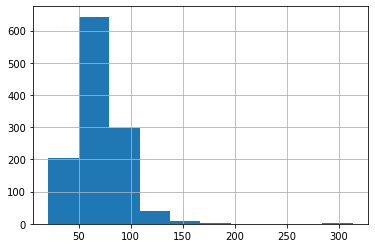

In [281]:
train4['LotFrontage'].hist()

In [282]:

train4['LotFrontage'] = train4.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

test4['LotFrontage'] = test4.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [283]:
test4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 77 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Id              1459 non-null   int64   
 1   MSSubClass      1459 non-null   category
 2   MSZoning        1459 non-null   category
 3   LotFrontage     1459 non-null   float64 
 4   LotArea         1459 non-null   int64   
 5   Street          1459 non-null   category
 6   Alley           1459 non-null   category
 7   LotShape        1459 non-null   category
 8   LandContour     1459 non-null   category
 9   Utilities       1459 non-null   category
 10  LotConfig       1459 non-null   category
 11  LandSlope       1459 non-null   category
 12  Neighborhood    1459 non-null   category
 13  Condition1      1459 non-null   category
 14  Condition2      1459 non-null   category
 15  BldgType        1459 non-null   category
 16  HouseStyle      1459 non-null   category
 17  OverallQual   

In [284]:
train4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 78 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Id              1460 non-null   int64   
 1   MSSubClass      1460 non-null   category
 2   MSZoning        1460 non-null   category
 3   LotFrontage     1460 non-null   float64 
 4   LotArea         1460 non-null   int64   
 5   Street          1460 non-null   category
 6   Alley           1460 non-null   category
 7   LotShape        1460 non-null   category
 8   LandContour     1460 non-null   category
 9   Utilities       1460 non-null   category
 10  LotConfig       1460 non-null   category
 11  LandSlope       1460 non-null   category
 12  Neighborhood    1460 non-null   category
 13  Condition1      1460 non-null   category
 14  Condition2      1460 non-null   category
 15  BldgType        1460 non-null   category
 16  HouseStyle      1460 non-null   category
 17  OverallQual   

# Data analysis of SalePrice (target)

In [285]:
train8 = train4.copy()
test8 = test4.copy()

SalePrice don't follows de normal distributions, so will be fit

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


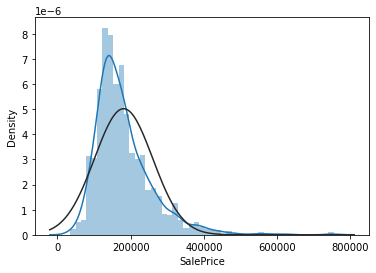

In [286]:
sns.distplot(train8['SalePrice'] , fit=norm)

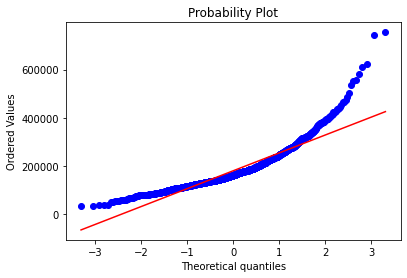

In [287]:
fig = plt.figure()
res = stats.probplot(train8['SalePrice'], plot=plt)
plt.show()

In [288]:
train8['SalePrice'] = np.log1p(train8['SalePrice'])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 12.024 and sigma = 0.399



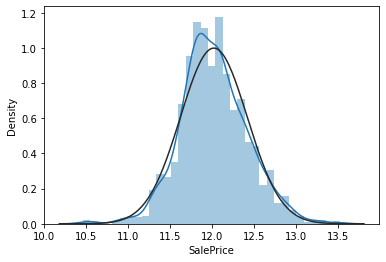

In [289]:
sns.distplot(train8['SalePrice'] , fit=norm);
(mu, sigma) = norm.fit(train8['SalePrice'])
print( '\n mu = {:.3f} and sigma = {:.3f}\n'.format(mu, sigma))

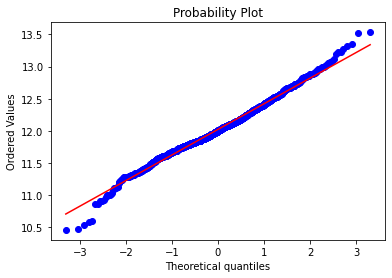

In [290]:
fig = plt.figure()
res = stats.probplot(train8['SalePrice'], plot=plt)
plt.show()

In [291]:
corr_= train8.corr().drop('Id', axis=1).drop('Id', axis=0)
corr_price_ = corr_.SalePrice.sort_values(ascending=False)
corr_price_pos = corr_price_[corr_price_>=0].sort_values(ascending=False)
corr_price_neg = corr_price_[corr_price_<0].sort_values()

corr_price = corr_price_pos.append(corr_price_neg)
features_cont_price = list(corr_price.index.drop('SalePrice'))
corr_price_

SalePrice         1.000000
Total_SF          0.777297
GrLivArea         0.700927
GarageArea        0.650888
Year_BuildRem     0.644833
All_Bath          0.639320
TotRmsAbvGrd      0.534422
Have_fireplace    0.510026
MasVnrArea        0.426776
BsmtFinSF1        0.372023
LotFrontage       0.353288
GarageYrBlt       0.349013
WoodDeckSF        0.334135
OpenPorchSF       0.321053
LotArea           0.257320
BsmtFullBath      0.236224
BsmtUnfSF         0.221985
BedroomAbvGr      0.209043
ScreenPorch       0.121208
PoolArea          0.069798
3SsnPorch         0.054900
BsmtFinSF2        0.004832
BsmtHalfBath     -0.005149
MiscVal          -0.020021
LowQualFinSF     -0.037963
KitchenAbvGr     -0.147548
EnclosedPorch    -0.149050
Name: SalePrice, dtype: float64

In [292]:
features_cont_price

['Total_SF',
 'GrLivArea',
 'GarageArea',
 'Year_BuildRem',
 'All_Bath',
 'TotRmsAbvGrd',
 'Have_fireplace',
 'MasVnrArea',
 'BsmtFinSF1',
 'LotFrontage',
 'GarageYrBlt',
 'WoodDeckSF',
 'OpenPorchSF',
 'LotArea',
 'BsmtFullBath',
 'BsmtUnfSF',
 'BedroomAbvGr',
 'ScreenPorch',
 'PoolArea',
 '3SsnPorch',
 'BsmtFinSF2',
 'EnclosedPorch',
 'KitchenAbvGr',
 'LowQualFinSF',
 'MiscVal',
 'BsmtHalfBath']

Remove skewness

In [293]:
skewed = train8[features_cont_price].apply(lambda x: skew(x.dropna()))
skewed=skewed[abs(skewed)>0.75]
skewed_data = pd.DataFrame({'Skew' :skewed.sort_values(ascending=False)})
print(skewed_data)
print(skewed_data.shape[0])



skewed_test = test8[features_cont_price].apply(lambda x: skew(x.dropna()))
skewed_test=skewed_test[abs(skewed_test)>0.75]
skewed_data_test = pd.DataFrame({'Skew' :skewed_test.sort_values(ascending=False)})
print(skewed_data_test)
print(skewed_data_test.shape[0])


                    Skew
MiscVal        24.451640
PoolArea       14.813135
LotArea        12.195142
3SsnPorch      10.293752
LowQualFinSF    9.002080
KitchenAbvGr    4.483784
BsmtFinSF2      4.250888
ScreenPorch     4.117977
BsmtHalfBath    4.099186
EnclosedPorch   3.086696
MasVnrArea      2.674865
OpenPorchSF     2.361912
LotFrontage     2.210685
Total_SF        1.774874
BsmtFinSF1      1.683771
WoodDeckSF      1.539792
GrLivArea       1.365156
BsmtUnfSF       0.919323
GarageYrBlt    -3.865524
19
                    Skew
PoolArea       20.176117
MiscVal        20.054543
LowQualFinSF   16.150628
3SsnPorch      12.511336
EnclosedPorch   4.664371
KitchenAbvGr    4.074860
BsmtFinSF2      4.038565
ScreenPorch     3.784349
BsmtHalfBath    3.779085
LotArea         3.112013
OpenPorchSF     2.685015
MasVnrArea      2.546947
WoodDeckSF      2.128569
Total_SF        1.214528
BsmtFinSF1      1.164877
GrLivArea       1.129240
BsmtUnfSF       0.919286
TotRmsAbvGrd    0.841731
GarageYrBlt    -3.9479

In [294]:
skewed_features = list(skewed_data.index)
lam = 0.15
for feat in skewed_features:
    train8[feat] = boxcox1p(train8[feat],lam)


skewed_features_test = list(skewed_data_test.index)
lam = 0.15
for feat in skewed_features_test:
    test8[feat] = boxcox1p(test8[feat],lam)

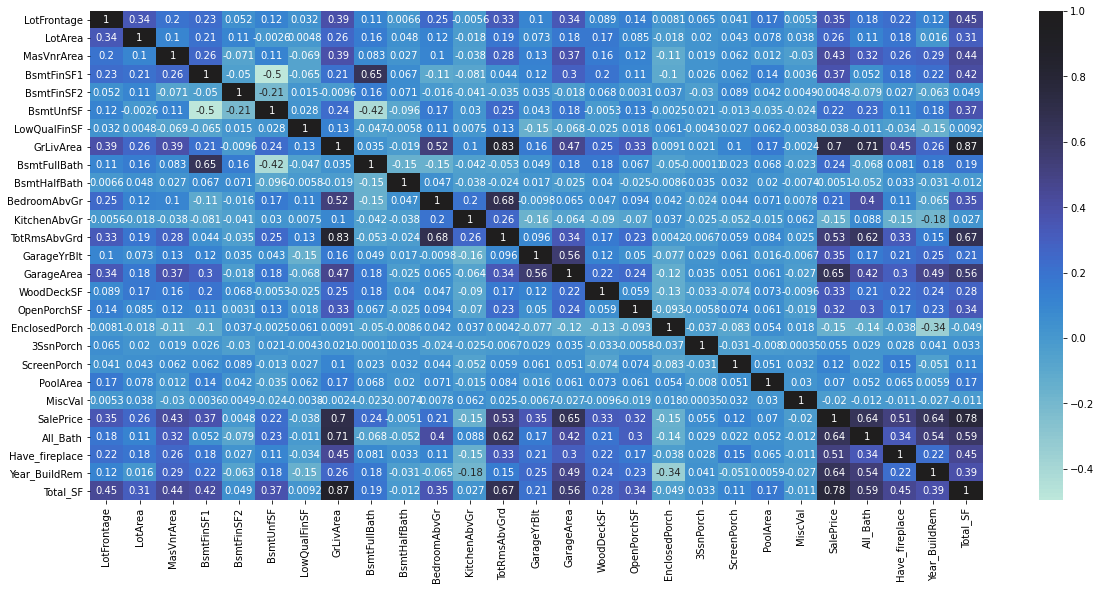

In [295]:
f2, ax2 = plt.subplots(figsize=(20,9))
sns.heatmap(corr_,annot=True,center=1)

In [296]:
features_cont_price.append('SalePrice')

# Drop the outliers

In [297]:
train9 = train8.copy()
test9 = test8.copy()

In [298]:
features_cont_price

['Total_SF',
 'GrLivArea',
 'GarageArea',
 'Year_BuildRem',
 'All_Bath',
 'TotRmsAbvGrd',
 'Have_fireplace',
 'MasVnrArea',
 'BsmtFinSF1',
 'LotFrontage',
 'GarageYrBlt',
 'WoodDeckSF',
 'OpenPorchSF',
 'LotArea',
 'BsmtFullBath',
 'BsmtUnfSF',
 'BedroomAbvGr',
 'ScreenPorch',
 'PoolArea',
 '3SsnPorch',
 'BsmtFinSF2',
 'EnclosedPorch',
 'KitchenAbvGr',
 'LowQualFinSF',
 'MiscVal',
 'BsmtHalfBath',
 'SalePrice']

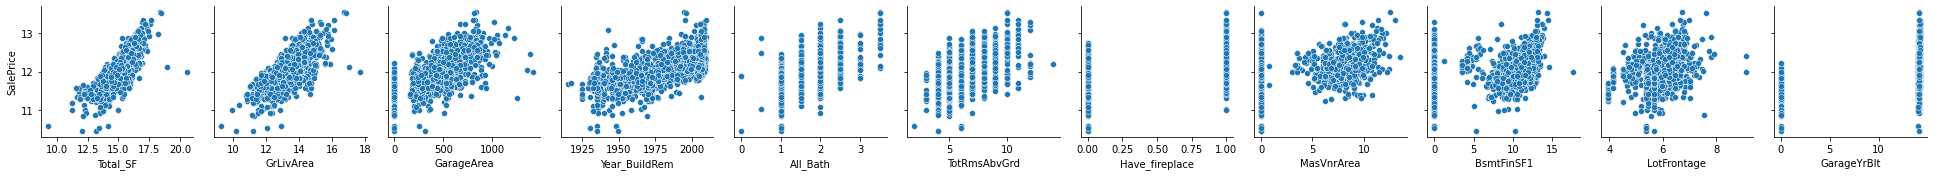

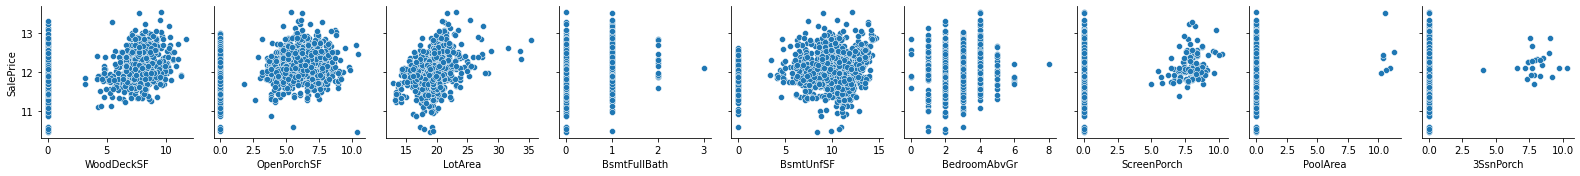

In [299]:
g = sns.PairGrid(train9[features_cont_price],x_vars=features_cont_price[:11],y_vars='SalePrice')
g.map(sns.scatterplot)
g = sns.PairGrid(train9[features_cont_price],x_vars=features_cont_price[11:20],y_vars='SalePrice')
g.map(sns.scatterplot)

Have some outliers in Total_SF

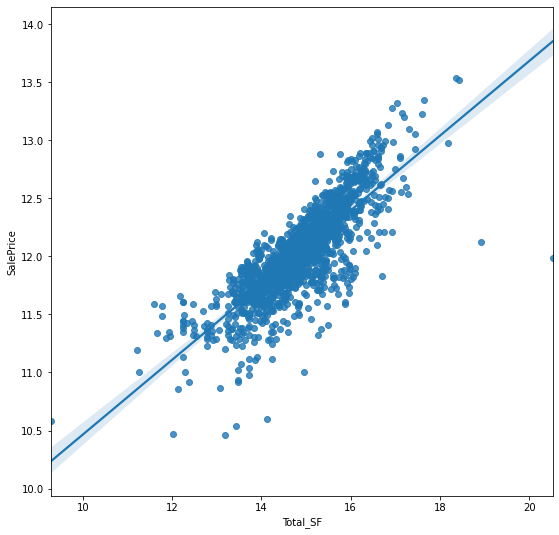

In [300]:
f1, ax1 = plt.subplots(figsize=(9,9))
sns.regplot(x='Total_SF',y='SalePrice',data=train9[features_cont_price])

In [301]:
train9 = train9.drop(train9[train9['Total_SF']>18].index)

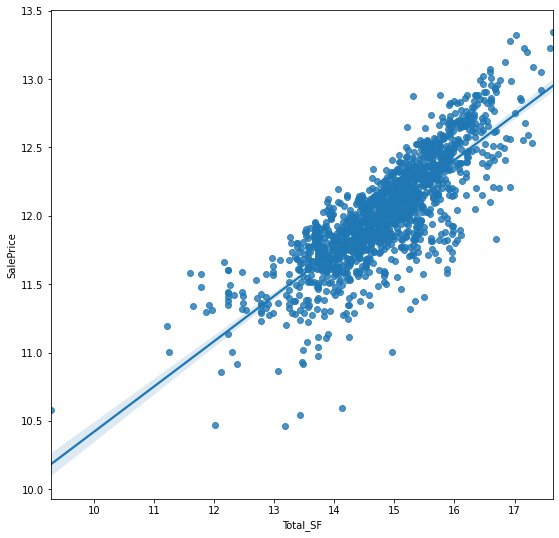

In [302]:
f1, ax1 = plt.subplots(figsize=(9,9))
sns.regplot(x='Total_SF',y='SalePrice',data=train9)

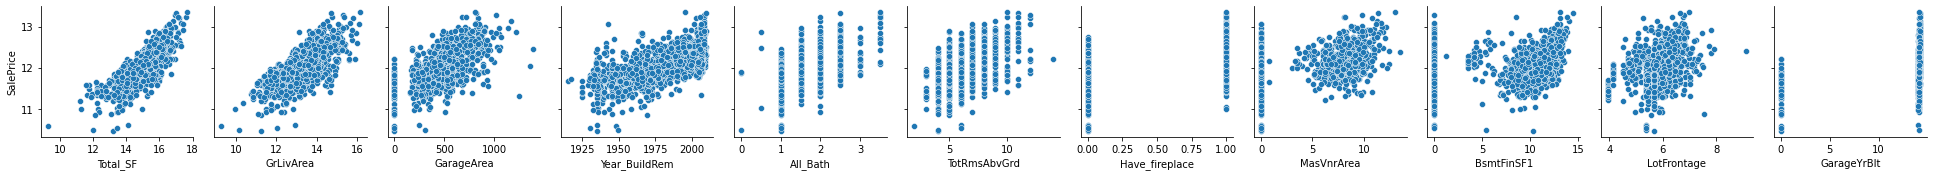

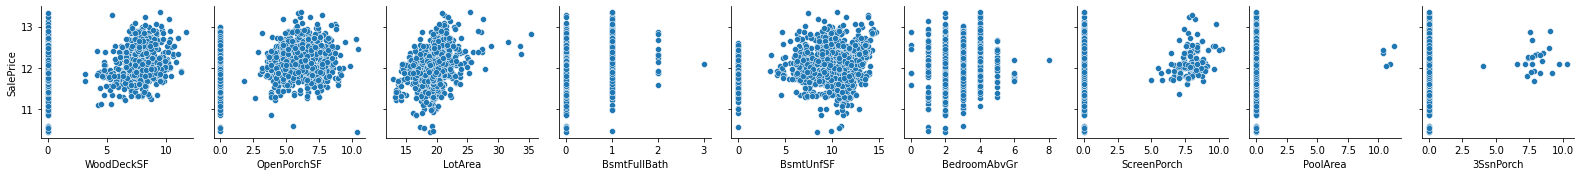

In [303]:
g = sns.PairGrid(train9[features_cont_price],x_vars=features_cont_price[:11],y_vars='SalePrice')
g.map(sns.scatterplot)
g = sns.PairGrid(train9[features_cont_price],x_vars=features_cont_price[11:20],y_vars='SalePrice')
g.map(sns.scatterplot)

In [304]:
train9[features_cont_price].corr().SalePrice.sort_values(ascending=False)

SalePrice         1.000000
Total_SF          0.818691
GrLivArea         0.731785
GarageArea        0.655958
Year_BuildRem     0.648470
All_Bath          0.635021
TotRmsAbvGrd      0.531782
Have_fireplace    0.510260
OpenPorchSF       0.455833
MasVnrArea        0.427817
LotArea           0.399850
LotFrontage       0.362279
WoodDeckSF        0.344935
GarageYrBlt       0.331028
BsmtFullBath      0.237586
BsmtFinSF1        0.228789
BsmtUnfSF         0.209785
BedroomAbvGr      0.202357
ScreenPorch       0.111598
3SsnPorch         0.060515
PoolArea          0.040780
BsmtHalfBath     -0.014543
BsmtFinSF2       -0.025270
LowQualFinSF     -0.052640
MiscVal          -0.062759
KitchenAbvGr     -0.145291
EnclosedPorch    -0.208291
Name: SalePrice, dtype: float64

# Machine Learning to predict the SalePrice values

# Data manipulation for ML Linear Regression



In [328]:
#Values to transform in dummies variables

encode2 = ['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1',
'Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation','Heating','HeatingQC',
 'CentralAir','Electrical','GarageType','Fence','MiscFeature','SaleType','SaleCondition']


In [329]:
test10 = test9.copy()
train10 = train9.copy()

In [330]:
train10.info()
test10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1455 entries, 0 to 1459
Data columns (total 78 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Id              1455 non-null   int64   
 1   MSSubClass      1455 non-null   category
 2   MSZoning        1455 non-null   category
 3   LotFrontage     1455 non-null   float64 
 4   LotArea         1455 non-null   float64 
 5   Street          1455 non-null   category
 6   Alley           1455 non-null   category
 7   LotShape        1455 non-null   category
 8   LandContour     1455 non-null   category
 9   Utilities       1455 non-null   category
 10  LotConfig       1455 non-null   category
 11  LandSlope       1455 non-null   category
 12  Neighborhood    1455 non-null   category
 13  Condition1      1455 non-null   category
 14  Condition2      1455 non-null   category
 15  BldgType        1455 non-null   category
 16  HouseStyle      1455 non-null   category
 17  OverallQual   

In [331]:
train_reg = pd.get_dummies(train10,columns=encode2, drop_first=True)
test_reg = pd.get_dummies(test10,columns=encode2, drop_first=True)

In [332]:
train_reg.shape

(1455, 223)

In [333]:
test_reg.shape

(1459, 207)

In [334]:
#Find the features that have in both datasets (test and train)
encode_test = [ele for ele in train_reg.columns if ele in test_reg.columns] 
len(encode_test)

206

In [335]:
print(encode_test)

['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscVal', 'MoSold', 'YrSold', 'All_Bath', 'Have_fireplace', 'Year_BuildRem', 'Total_SF', 'MSSubClass_B', 'MSSubClass_C', 'MSSubClass_D', 'MSSubClass_E', 'MSSubClass_F', 'MSSubClass_G', 'MSSubClass_H', 'MSSubClass_I', 'MSSubClass_J', 'MSSubClass_L', 'MSSubClass_M', 'MSSubClass_O', 'MSSubClass_P', 'MSSubClass_Q', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Street_Pave', 'Alley_NA', 'Alley_Pave', 'LotS

In [339]:
#Put the same features of test set plus the SalePrice
encode_train =['Id','SalePrice','LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscVal', 'MoSold', 'YrSold', 'All_Bath', 'Have_fireplace', 'Year_BuildRem', 'Total_SF', 'MSSubClass_B', 'MSSubClass_C', 'MSSubClass_D', 'MSSubClass_E', 'MSSubClass_F', 'MSSubClass_G', 'MSSubClass_H', 'MSSubClass_I', 'MSSubClass_J', 'MSSubClass_L', 'MSSubClass_M', 'MSSubClass_O', 'MSSubClass_P', 'MSSubClass_Q', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Street_Pave', 'Alley_NA', 'Alley_Pave', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker', 'Condition1_Feedr', 'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Feedr', 'Condition2_Norm', 'Condition2_PosA', 'Condition2_PosN', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'HouseStyle_1.5Unf', 'HouseStyle_1Story', 'HouseStyle_2.5Unf', 'HouseStyle_2Story', 'HouseStyle_SFoyer', 'HouseStyle_SLvl', 'RoofStyle_Gable', 'RoofStyle_Gambrel', 'RoofStyle_Hip', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_CemntBd', 'Exterior1st_HdBoard', 'Exterior1st_MetalSd', 'Exterior1st_Plywood', 'Exterior1st_Stucco', 'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng', 'Exterior1st_WdShing', 'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn', 'Exterior2nd_BrkFace', 'Exterior2nd_CBlock', 'Exterior2nd_CmentBd', 'Exterior2nd_HdBoard', 'Exterior2nd_ImStucc', 'Exterior2nd_MetalSd', 'Exterior2nd_Plywood', 'Exterior2nd_Stone', 'Exterior2nd_Stucco', 'Exterior2nd_VinylSd', 'Exterior2nd_Wd Sdng', 'Exterior2nd_Wd Shng', 'MasVnrType_BrkFace', 'MasVnrType_None', 'MasVnrType_Stone', 'Foundation_CBlock', 'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone', 'Foundation_Wood', 'Heating_GasW', 'Heating_Grav', 'Heating_Wall', 'HeatingQC_2', 'HeatingQC_4', 'HeatingQC_1', 'HeatingQC_3', 'CentralAir_1', 'Electrical_FuseF', 'Electrical_FuseP', 'Electrical_SBrkr', 'GarageType_Attchd', 'GarageType_Basment', 'GarageType_BuiltIn', 'GarageType_CarPort', 'GarageType_Detchd', 'GarageType_NA', 'Fence_GdWo', 'Fence_MnPrv', 'Fence_MnWw', 'Fence_NA', 'MiscFeature_NA', 'MiscFeature_Othr', 'MiscFeature_Shed', 'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal', 'SaleCondition_Partial']

In [340]:
train_reg[encode_train].shape

(1455, 207)

In [341]:
test_reg[encode_test].shape

(1459, 206)

In [342]:
#See the correlation and sorting in descending order - absolute values
corr2= train_reg[encode_train].corr().SalePrice.drop(['Id'])
features = list((abs(corr2).sort_values(ascending=False)).index)
corr_all = corr2[features]
features = features[1:]
print(features)
print(corr_all[:100])

['Total_SF', 'GrLivArea', 'GarageArea', 'Year_BuildRem', 'All_Bath', 'TotRmsAbvGrd', 'Foundation_PConc', 'Have_fireplace', 'OpenPorchSF', 'MasVnrArea', 'GarageType_Attchd', 'LotArea', 'MSSubClass_F', 'MasVnrType_None', 'GarageType_Detchd', 'LotFrontage', 'Neighborhood_NridgHt', 'CentralAir_1', 'MSZoning_RM', 'Exterior2nd_VinylSd', 'Exterior1st_VinylSd', 'WoodDeckSF', 'SaleType_New', 'Foundation_CBlock', 'HeatingQC_3', 'SaleCondition_Partial', 'MSSubClass_B', 'GarageYrBlt', 'GarageType_NA', 'MasVnrType_Stone', 'Electrical_SBrkr', 'MSZoning_RL', 'LotShape_Reg', 'HouseStyle_2Story', 'Neighborhood_NoRidge', 'BsmtFullBath', 'Neighborhood_IDOTRR', 'MasVnrType_BrkFace', 'Neighborhood_OldTown', 'BsmtFinSF1', 'GarageType_BuiltIn', 'SaleType_WD', 'Neighborhood_Edwards', 'BsmtUnfSF', 'EnclosedPorch', 'BedroomAbvGr', 'Exterior1st_Wd Sdng', 'RoofStyle_Hip', 'Neighborhood_StoneBr', 'RoofStyle_Gable', 'Exterior2nd_Wd Sdng', 'Fence_NA', 'HeatingQC_2', 'Neighborhood_BrkSide', 'Neighborhood_Somerst', 'M

In [343]:
train_reg[features].shape

(1455, 184)

In [344]:
test_reg[features].shape

(1459, 184)

# Machine Learning
1. Lasso to decrease the multicollinearity by put coefficients = 0 in to features not important. 
2. Prediction LinearRegression with Lasso features (or Lasso predict) 
2. XgboostRegressor with Bayesian optimizator BayesSearchCV

#Lasso


In [345]:
y = train_reg['SalePrice']
X = train_reg[features]
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0,test_size=0.25)

In [136]:
ls = Lasso(random_state=0, max_iter=-1)

param = {'ls__alpha': np.linspace(0.00016,0.00017,201)}
                    
pipe = Pipeline([('RobustScaler',RobustScaler()),('ls',ls)])

In [138]:
cv = GridSearchCV(pipe,param,cv=5, scoring='neg_root_mean_squared_error').fit(X_train,y_train)

print('Best params Lasso: {}'.format(ls_cv.best_params_))
print('Best score Lasso: {}'.format(-ls_cv.best_score_))


KeyboardInterrupt: ignored

Best params Lasso: {'alpha': 0.00016315}
Best score Lasso: 0.12905565062032714

In [346]:
ls = Lasso(alpha=0.00016315,random_state=0).fit(X_train,y_train)

ls_cv = cross_val_score(ls,X_train,y_train,n_jobs=-1,cv=5,scoring='neg_root_mean_squared_error')


RMSE = (-ls_cv) 
print('Cross validation Scores:\n', (RMSE))
print('Cross validation Scores Média:\n', (RMSE.mean()))

y_pred_ls = ls.predict(X_test)

RMSLE_pred = math.sqrt(mean_squared_error(y_test,y_pred_ls))

print('RMSE', RMSLE_pred)
print('Score test {:.4f}'.format(ls.score(X_test,y_test)))
print('Score train: {:.4f}'.format(ls.score(X_train,y_train)))
print("Number of features used: {}".format(np.sum(ls.coef_!= 0)))



Cross validation Scores:
 [0.14188149 0.14613616 0.16147681 0.12328722 0.13052455]
Cross validation Scores Média:
 0.140661244529091
RMSE 0.1256170271404205
Score test 0.8918
Score train: 0.9226
Number of features used: 131


In [347]:
all_features_lasso = list(zip(features,ls.coef_))
all_features_lasso
coef_ls = [list(x) for x in all_features_lasso]
coef_ls

coef_ls = pd.DataFrame(coef_ls,columns=['feature','coef'])

#Just the coef different of zero
coef_importance = coef_ls[coef_ls['coef']!=0].set_index('feature')

#For ordering de importance without influence of negative coef, will be use the absolute values
coef_importance = abs(coef_importance).sort_values(by='coef', ascending=False)
features_importance_ls = list(coef_importance.index)

In [348]:
len(features_importance_ls)

131

In [ ]:
#Confirming if these features are the best for linear regression
#scoring='neg_root_mean_squared_error'

result = {}
best_params = {}
features_ = [] 


for feature in features_importance_ls:

  features_.append(feature)
  y = train_reg['SalePrice']
  X = RobustScaler().fit_transform(train_reg[features_])

  lr = LinearRegression()
  lr.fit(X_train,y_train)

  lr_gr= cross_val_score(lr,X_train,y_train,n_jobs=-1,cv=5)

  result[len(features_)]= lr_gr.mean()

best_score = max(zip(result.values(),result.keys()))
print(best_score)

(0.8752457144263994, 131)


In [349]:
y = train_reg['SalePrice']
X = train_reg[features_importance_ls]
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0,test_size=0.25)
X_train = RobustScaler().fit_transform(X_train)
X_test = RobustScaler().fit_transform(X_test)

#LinearRegression

In [ ]:
#scoring='neg_root_mean_squared_error'
lr = LinearRegression().fit(X_train,y_train)

lr_cv = cross_val_score(lr,X_train,y_train,n_jobs=-1,cv=5,scoring='neg_root_mean_squared_error')

print('Linear Regression RMSE:{}'.format(lr_cv))
print('Linear Regression Mean RMSE:{}'.format(lr_cv.mean()))
print('R2 Train:{}'.format(lr.score(X_train,y_train)))
print('R2 Test: {}'.format(lr.score(X_test,y_test)))

Linear Regression RMSE:[-0.1379446  -0.1407962  -0.16512439 -0.12104286 -0.13351455]
Linear Regression Mean RMSE:-0.13968451962522702
R2 Train:0.9254903890550269
R2 Test: 0.8708893893606112


#LR predict
Kaggle = 0.16962

In [ ]:
X_true = RobustScaler().fit_transform(test_reg[features_importance_ls])

lr_true = LinearRegression().fit(X_train,y_train)

y_pred_lr = np.expm1(lr_true.predict(X_true))

output = pd.DataFrame({'Id':test_reg.Id, 'SalePrice': y_pred_lr})
output.to_csv('Sale_Price[8]_lr6.csv', index=False)


# BayesSearchCV with XGBoostRegressor
Kaggle = 0.15257

In [ ]:
xgb_reg = XGBRegressor(random_state=0, n_jobs=-1, objective='reg:squarederror')

space = {'max_depth': [2,3,4,5,6,7,8,9,10],
         'n_estimators':(3000,5500,'uniform'),
         'learning_rate':(0.0001,0.001,'uniform'),
         'colsample_bytree':(0.1,0.99,'uniform'),
         'subsample':(0.1,0.99,'uniform'),
         'min_child_weight':(0.1,0.99,'uniform')}


opt = BayesSearchCV(xgb_reg,search_spaces=space,random_state=0,n_iter=100,scoring='neg_root_mean_squared_error').fit(X_train,y_train)

In [171]:
print('Best params achieve a test score of', abs(opt.score(X_test, y_test)), ':')
print('Best params achieve a train score of', abs(opt.best_score_),':')
opt.best_params_


Best params achieve a test score of 0.1299428741488591 :
Best params achieve a train score of 0.1340001159689223 :


OrderedDict([('colsample_bytree', 0.24422594358535155),
             ('learning_rate', 0.005349798812018981),
             ('max_depth', 7),
             ('min_child_weight', 0),
             ('n_estimators', 4227),
             ('subsample', 0.3036166233116627)])

In [353]:
mtrain = xgb.DMatrix(X_train,label=y_train)
mtest = xgb.DMatrix(X_test,label=y_test)

In [178]:
params = {'colsample_bytree': 0.3676,
 'learning_rate': 0.004964,
 'max_depth': 6,
 'min_child_weight': 0.243,
 'n_estimators': 3000,
 'subsample': 0.1838}




cv_results = xgb.cv(dtrain=mtrain,params=params,metrics='rmse',early_stopping_rounds=25,num_boost_round=5000, seed=123,
                    as_pandas=True, nfold=5)
print(cv_results["test-rmse-mean"])#.tail().values[-1])




xg_reg = XGBRegressor(objective="reg:squarederror",colsample_bytree=0.3676,learning_rate=0.004964,max_depth=6,
                          min_child_weight=0.243,n_estimators=3000,subsample=0.1838,random_state=0,n_jobs=-1,
                      early_stopping_rounds=25,num_boost_round=5000).fit(X_train, y_train)

xg_pred = xg_reg.predict(X_test)


print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test, xg_pred)))
print('R train: {}'.format(xg_reg.score(X_train,y_train)))
print('R test: {}'.format(xg_reg.score(X_test,y_test)))


0       11.482096
1       11.425584
2       11.369253
3       11.313354
4       11.257629
          ...    
2378     0.135031
2379     0.135047
2380     0.135035
2381     0.135022
2382     0.135021
Name: test-rmse-mean, Length: 2383, dtype: float64
Root Mean Squared Error: 0.12570734736698327
R train: 0.9719487803802809
R test: 0.8916893532269452


In [182]:
xgb_features_imp  = pd.DataFrame({'features':features_importance_ls,'importances': xg_reg.feature_importances_})
xgb_features_imp = xgb_features_imp.sort_values(by='importances',ascending=False)
print(xgb_features_imp)

                  features  importances
13                Total_SF     0.028329
43       RoofStyle_Gambrel     0.026321
0      Exterior1st_BrkComm     0.026121
18            CentralAir_1     0.025312
116          Year_BuildRem     0.024561
73          Have_fireplace     0.024061
129             GarageArea     0.019874
30     Neighborhood_IDOTRR     0.019751
36               GrLivArea     0.018232
63                All_Bath     0.015528
130           MSSubClass_L     0.014697
53     Exterior2nd_BrkFace     0.014662
25            MSSubClass_B     0.013875
121            GarageYrBlt     0.013802
72        Foundation_PConc     0.013653
16      GarageType_CarPort     0.012265
22              Fence_GdWo     0.011771
9              Street_Pave     0.011725
118        BldgType_Duplex     0.011683
85              Alley_Pave     0.011237
35    SaleCondition_Alloca     0.011020
10     Exterior1st_BrkFace     0.010985
6         RoofMatl_WdShngl     0.010092
112             BsmtFinSF1     0.010053


In [354]:
test_reg[features_importance_ls].shape

(1459, 131)

In [355]:
train_reg[features_importance_ls].shape

(1455, 131)

In [397]:
X_true = RobustScaler().fit_transform(test_reg[features_importance_ls])

predict_xgb = np.expm1(xg_reg.predict(X_true))

In [398]:
output = pd.DataFrame({'Id': test_id, 'SalePrice': predict_xgb})
output.to_csv('Sale_Price[8]_XGB2.csv', index=False)

In [399]:
mre = np.sqrt(mean_squared_log_error(best_sub,output))
mre

0.06865834282915183

In [400]:
min(predict_xgb)

49347.59

In [401]:
max(predict_xgb)

596176.7